In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

def is_image_file(filename):
    """
    Check if the file is an image file
    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp']
    return any(filename.lower().endswith(ext) for ext in image_extensions)

def load_images(folder):
    images = []
    skipped_files = []

    # List all files in the folder
    all_files = os.listdir(folder)
    print(f"Total files in {folder}: {all_files}")

    # Filter image files
    image_files = [f for f in all_files if is_image_file(f)]
    print(f"Image files found: {image_files}")

    for filename in image_files:
        try:
            # Full path to the image
            img_path = os.path.join(folder, filename)

            # Read image with error handling
            img = cv2.imread(img_path)

            # Check if image is None (failed to read)
            if img is None:
                print(f"Failed to read image: {img_path}")
                skipped_files.append(filename)
                continue

            # Convert color space from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Normalize pixel values
            img = img.astype(np.float32) / 255.0

            # Resize image
            img = cv2.resize(img, (256, 256))

            images.append(img)

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            skipped_files.append(filename)

    # Print summary
    print(f"Successfully loaded {len(images)} images")
    if skipped_files:
        print(f"Skipped files: {skipped_files}")

    return np.array(images)

# Define folder paths
with_reflection_folder = '/content/drive/MyDrive/Train/TRAIN/with reflection images'
without_reflection_folder = '/content/drive/MyDrive/Train/TRAIN/without reflection images'
test_cases_folder = '/content/drive/MyDrive/Test /TEST'

# Load images from each folder
with_reflection_images = load_images(with_reflection_folder)
without_reflection_images = load_images(without_reflection_folder)
test_cases_images = load_images(test_cases_folder)

# Split the dataset into training and validation subsets
train_images = with_reflection_images[:8]
train_labels = without_reflection_images[:8]
val_images = with_reflection_images[8:]
val_labels = without_reflection_images[8:]

# Print dataset sizes
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Total files in /content/drive/MyDrive/Train/TRAIN/with reflection images: ['1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg', '10.jpeg', '11.jpeg', '12.jpeg', '13.jpeg', '14.jpeg', '.DS_Store']
Image files found: ['1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg', '10.jpeg', '11.jpeg', '12.jpeg', '13.jpeg', '14.jpeg']
Successfully loaded 14 images
Total files in /content/drive/MyDrive/Train/TRAIN/without reflection images: ['1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', "8'.jpeg", "9'.jpeg", '10.jpeg', '11.jpeg', '12.jpeg', '14.jpeg', '13.jpeg', '.DS_Store']
Image files found: ['1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', "8'.jpeg", "9'.jpeg", '10.jpeg', '11.jpeg', '12.jpeg', '14.jpeg', '13.jpeg']
Successfully loaded 14 images
Total files in /content/drive/MyDrive/Test /TEST: ['1.jpeg', '3.jpeg']
Image files found: ['1.jpeg', '3.jpeg']
Successfully loaded 2 imag

In [ ]:
# Enhanced U-Net architecture with padding to maintain spatial dimensions
def build_unet(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder (Downsampling)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder (Upsampling)
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up1 = concatenate([up1, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up2 = concatenate([up2, conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up2)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up3 = concatenate([up3, conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up4 = concatenate([up4, conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up4)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Final layer
    outputs = Conv2D(3, 1, activation='sigmoid', padding='same')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Combined loss function
import tensorflow.keras.backend as K

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def combined_loss(y_true, y_pred):
    return 0.5 * K.mean(K.square(y_pred - y_true)) + 0.5 * ssim_loss(y_true, y_pred)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Build and compile the U-Net model
unet_model = build_unet(input_shape=(256, 256, 3))
unet_model.compile(optimizer='adam', loss=combined_loss, metrics=['mae'])

# Print model summary
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,031,875 (118.38 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = unet_model.fit(
    datagen.flow(train_images, train_labels, batch_size=1),
    epochs=35,
    validation_data=(val_images, val_labels),
    callbacks=[lr_scheduler]
)

Epoch 1/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 90s 11s/step - loss: 0.2975 - mae: 0.2227 - val_loss: 0.2781 - val_mae: 0.1923 - learning_rate: 5.0000e-04
Epoch 2/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 93s 12s/step - loss: 0.2231 - mae: 0.1841 - val_loss: 0.2783 - val_mae: 0.1921 - learning_rate: 5.0000e-04
Epoch 3/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 86s 11s/step - loss: 0.2788 - mae: 0.2148 - val_loss: 0.2829 - val_mae: 0.1933 - learning_rate: 5.0000e-04
Epoch 4/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 88s 11s/step - loss: 0.2808 - mae: 0.2066 - val_loss: 0.2817 - val_mae: 0.1976 - learning_rate: 5.0000e-04
Epoch 5/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 95s 12s/step - loss: 0.2292 - mae: 0.1868 - val_loss: 0.2803 - val_mae: 0.1937 - learning_rate: 5.0000e-04
Epoch 6/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 12s/step - loss: 0.2676 - mae: 0.2027 - val_loss: 0.2818 - val_mae: 0.1939 - learning_rate: 5.0000e-04
Epoch 7/35
8/8 ━━━━━━━━━━━━━━━━━━━━ 85s 11s/step - loss: 0.2906 - mae: 0.2122 - val_loss: 0.2786 - val_mae: 0.1897 - learning_rate: 2.5000e-04

In [ ]:
unet_model_save_path = '/content/drive/MyDrive/reflection/unet_model.h5'
unet_model.save(unet_model_save_path)

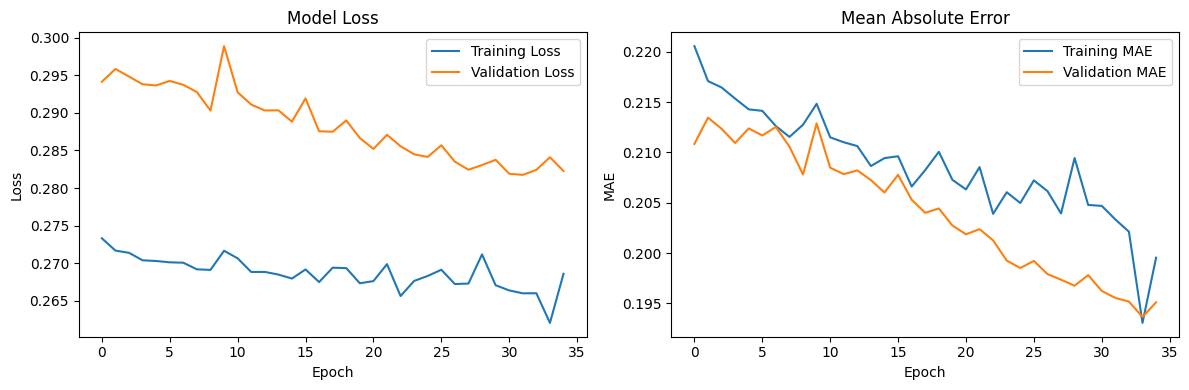

In [ ]:
# Optional: Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

# Evaluate the model on the validation dataset
evaluation_results = unet_model.evaluate(val_images, val_labels)

if isinstance(evaluation_results, list):
    loss = evaluation_results[0]
    mae = evaluation_results[1] if len(evaluation_results) > 1 else None

    print(f'Validation loss: {loss:.4f}')
    if mae is not None:
        print(f'Validation MAE: {mae:.4f}')
else:
    print(f'Validation loss: {evaluation_results:.4f}')

# Ensure output folder exists
output_folder = 'output/'
os.makedirs(output_folder, exist_ok=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.2823 - mae: 0.1951
Validation loss: 0.2823
Validation MAE: 0.1951


In [ ]:
# Run the trained model on the test images
test_outputs = unet_model.predict(test_cases_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
# Function to post-process and save images
def process_and_save_image(output, index):
    output = np.clip(output * 255, 0, 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
    output_path = os.path.join(output_folder, f'test_{index}.jpeg')
    cv2.imwrite(output_path, img_bgr)
    return output

# Visualization function
def visualize_results(original, output, index):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Reflection Removed')
    plt.imshow(output)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Comparison')
    comparison = np.hstack([original, output])
    plt.imshow(comparison)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


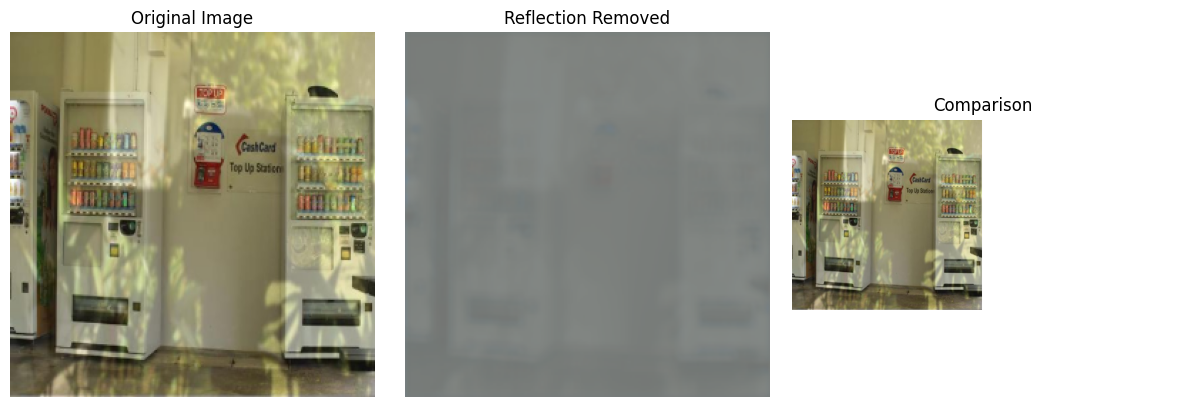

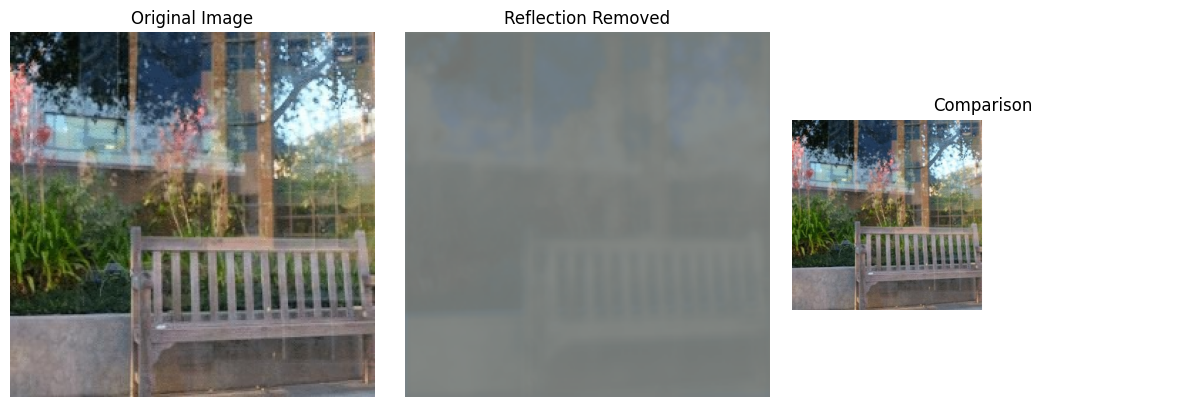

In [ ]:

# Process and save test images
processed_outputs = []
for i, (test_img, output) in enumerate(zip(test_cases_images, test_outputs)):
    processed_output = process_and_save_image(output, i)
    processed_outputs.append(processed_output)
    visualize_results(test_img, processed_output, i)